In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import scienceplots
%matplotlib inline
from seaborn import displot, histplot
plt.style.use(['seaborn-v0_8-paper'])
from tqdm import tqdm
from shapely.geometry import LineString
from conflict import ConflictLyft
from scipy import stats
import statsmodels.api as sm 

## Data process

In [2]:
with open('./lyft_avhv_conflict.pkl', 'rb') as file:
    lyft_avhv_conflict_list = pickle.load(file)

with open('./lyft_hvhv_conflict.pkl', 'rb') as file:
    lyft_hvhv_conflict_list = pickle.load(file)

lyft_conflict_list = lyft_avhv_conflict_list + lyft_hvhv_conflict_list

# convert the type to latest conflict object
conflict_list = list()
for c_index, c in enumerate(lyft_conflict_list):
    # print(c_index)
    conflict_list.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
    ))
assert len(conflict_list) == len(lyft_conflict_list)

In [3]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()

for index, conflict in tqdm(enumerate(conflict_list)):
    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    conflict_rows_in_df.append([
        conflict_type,
        leader_type+"-"+follower_type,
        conflict.PET,
    ])
conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info()

1745it [00:00, 497218.78it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1745 entries, 0 to 1744
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  1745 non-null   object 
 1   Vehicle order  1745 non-null   object 
 2   PET            1745 non-null   float64
dtypes: float64(1), object(2)
memory usage: 54.5+ KB


#Conflicts

In [4]:
conflict_df["Conflict type"].value_counts()

Merge    1134
Cross     611
Name: Conflict type, dtype: int64

In [5]:
conflict_df[["Conflict type", "Vehicle order"]].value_counts()

Conflict type  Vehicle order
Merge          HV-HV            793
Cross          HV-HV            456
Merge          HV-AV            190
               AV-HV            151
Cross          HV-AV             93
               AV-HV             62
dtype: int64

Mean

In [6]:
# mean
conflict_df.groupby(["Conflict type", "Vehicle order"])['PET'].mean()

Conflict type  Vehicle order
Cross          AV-HV            3.845161
               HV-AV            7.346237
               HV-HV            4.675219
Merge          AV-HV            3.331126
               HV-AV            7.075789
               HV-HV            4.624842
Name: PET, dtype: float64

Std

In [7]:
# std 
conflict_df.groupby(["Conflict type", "Vehicle order"])['PET'].std()

Conflict type  Vehicle order
Cross          AV-HV            1.273909
               HV-AV            1.300715
               HV-HV            2.175200
Merge          AV-HV            1.678975
               HV-AV            1.894588
               HV-HV            2.378444
Name: PET, dtype: float64

In [8]:
cross_df = conflict_df[conflict_df["Conflict type"] == "Cross"]
merge_df = conflict_df[conflict_df["Conflict type"] == "Merge"]

HVHV_cross = cross_df[cross_df["Vehicle order"] == "HV-HV"]
AVHV_cross = cross_df[cross_df["Vehicle order"] == "AV-HV"]
HVAV_cross = cross_df[cross_df["Vehicle order"] == "HV-AV"]

HVHV_merge = merge_df[merge_df["Vehicle order"] == "HV-HV"]
AVHV_merge = merge_df[merge_df["Vehicle order"] == "AV-HV"]
HVAV_merge = merge_df[merge_df["Vehicle order"] == "HV-AV"]

In [9]:
conflict_df.to_csv("./outputs/trb/lyft_pet.csv", index=False)

## Stats Test

### Normality Test

In [78]:
# HVHV::Cross
stats.shapiro(HVHV_cross.PET).pvalue # 4.0118783295461924e-11

# AVHV::Cross
stats.shapiro(AVHV_cross.PET).pvalue # 0.022226838394999504

# HVAV::Cross
stats.shapiro(HVAV_cross.PET).pvalue # 0.0005004151607863605

# HVHV::Merge
stats.shapiro(HVHV_merge.PET).pvalue # 2.2616701998072816e-18

# AVHV::Merge
stats.shapiro(AVHV_merge.PET).pvalue # 1.682047903739381e-11

# HVAV::Merge
stats.shapiro(HVAV_merge.PET).pvalue # 1.6619397911199485e-06

1.6619397911199485e-06

### Mann-Whitney U Test

In [12]:
# HVHV::HVAV | Cross
stats.mannwhitneyu(x=HVHV_cross.PET, y=HVAV_cross.PET, alternative="two-sided").pvalue # 3.3968684980172054e-25

# HVHV::AVHV | Cross
stats.mannwhitneyu(x=HVHV_cross.PET, y=AVHV_cross.PET, alternative="two-sided").pvalue # 0.005834042105093738

# HVHV::HVAV | Merge
stats.mannwhitneyu(HVHV_merge.PET, HVAV_merge.PET, alternative="two-sided").pvalue # 4.320736121733289e-33

# HVHV::AVHV | Merge
stats.mannwhitneyu(HVHV_merge.PET, AVHV_merge.PET, alternative="two-sided").pvalue # 6.473436096260261e-12

# AVHV::HVAV | Cross
stats.mannwhitneyu(AVHV_cross.PET, HVAV_cross.PET, alternative="two-sided").pvalue # 7.322476713102058e-23

# AVHV::HVAV | Merge
stats.mannwhitneyu(AVHV_merge.PET, HVAV_merge.PET, alternative="two-sided").pvalue # 1.0461366620748009e-38


1.0461366620748009e-38

### T-Test

In [15]:
# HVHV::HVAV | Cross
stats.ttest_ind(HVHV_cross.PET, HVAV_cross.PET).pvalue # 2.8717940787212612e-27

# HVHV::AVHV | Cross
stats.ttest_ind(HVHV_cross.PET, AVHV_cross.PET).pvalue # 0.003478778612099769

# HVHV::HVAV | Merge
stats.ttest_ind(HVHV_merge.PET, HVAV_merge.PET).pvalue # 6.750517798820859e-37

# HVHV::AVHV | Merge
stats.ttest_ind(HVHV_merge.PET, AVHV_merge.PET).pvalue # 2.661792417462183e-10

# AVHV::HVAV | Cross
stats.ttest_ind(AVHV_cross.PET, HVAV_cross.PET,).pvalue # 6.415030209689625e-36

# AVHV::HVAV | Merge
stats.ttest_ind(AVHV_merge.PET, HVAV_merge.PET).pvalue # 1.4961574697278332e-55

1.4961574697278332e-55

### ANOVA

In [57]:
# Merge
stats.f_oneway(HVHV_merge.PET, HVAV_merge.PET, AVHV_merge.PET).pvalue # 3.3339397298706515e-53

# Cross
stats.f_oneway(HVHV_cross.PET, HVAV_cross.PET, AVHV_cross.PET).pvalue # 5.737005309103852e-32

5.737005309103852e-32

## Draw distributions

### Total

<Figure size 300x300 with 0 Axes>

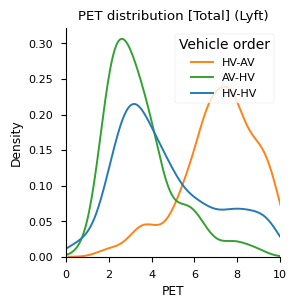

In [59]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

HVHV_COLOR = '#257ab6'
HVAV_COLOR = '#31a231'
AVHV_COLOR = '#ff8214'

FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df,
    x="PET", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0,PET_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title("PET distribution [Total] (Lyft)")
# plt.savefig("./outputs/plots/lyft_distribution_PET_Total.png", dpi=300, bbox_inches="tight")
plt.show()

### Merge

<Figure size 300x300 with 0 Axes>

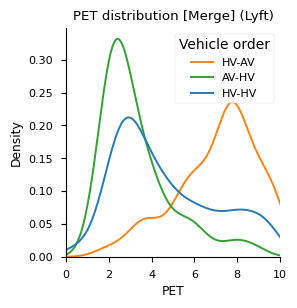

In [60]:
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]=="Merge"],
    x="PET", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0,PET_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title("PET distribution [Merge] (Lyft)")
# plt.savefig("./outputs/plots/lyft_distribution_PET_Merge.png", dpi=300, bbox_inches="tight")
plt.show()

### Cross

<Figure size 300x300 with 0 Axes>

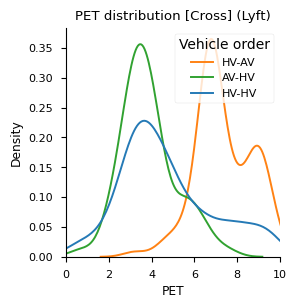

In [61]:
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]=="Cross"],
    x="PET", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0,PET_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title("PET distribution [Cross] (Lyft)")
# plt.savefig("./outputs/plots/lyft_distribution_PET_Cross.png", dpi=300, bbox_inches="tight")
plt.show()